In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load data from Google Spreadsheet
SHEET_ID = '1JDNv_mArl-GPIpxuWS5GxgVEwvjXocS1MrXGc6TYs8M'
SHEET_NAME = ['USD/IDR', 'EUR/IDR', 'JPY/IDR']

In [2]:
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME[0]}'
data = pd.read_csv(url)

# Drop unused columns
data = data.drop('Unnamed: 2', axis=1)

# Convert Date columns to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y %H:%M:%S')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1977 entries, 0 to 1976
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1977 non-null   datetime64[ns]
 1   Close   1977 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 31.0 KB


In [3]:
data = data.groupby([pd.Grouper(key='Date', freq='D')]).first().reset_index()
data = data.set_index('Date')

In [4]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define the number of previous time steps to consider for forecasting
n_steps = 60

# Split the data into input (X) and output (y) sequences
X, y = [], []
for i in range(n_steps, len(scaled_data)):
    X.append(scaled_data[i - n_steps:i])
    y.append(scaled_data[i])

X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [5]:
X_train.shape

(1533, 60, 1)

In [6]:
# Step 2: Build and train the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_steps, X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

1/1 [==============================] - 0s 18ms/step
See Plot for Future Predictions


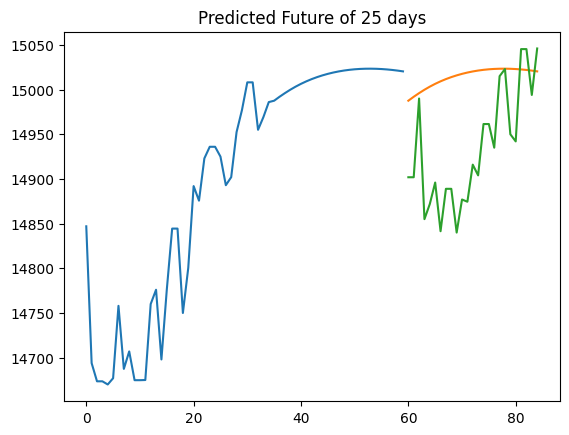

In [13]:
# Step 3: Make predictions for future time steps
SHEET_ID_TEST = '1t0htaF2pVQUwb-bVaIafHe5-mtEFrmdqJHrtn9XtHWI'
actual = pd.read_csv(f'https://docs.google.com/spreadsheets/d/{SHEET_ID_TEST}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME[0]}')

future_steps = 25  # Number of time steps to forecast into the future
last_sequence = X_test[-1]  # Get the last sequence from the testing data

predictions = []
for _ in range(future_steps):
    prediction = model.predict(np.array([last_sequence]))  # Predict the next time step
    predictions.append(prediction)
    last_sequence = np.concatenate((last_sequence[1:], prediction), axis=0)

predictions = np.array(predictions)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
last_sequence = scaler.inverse_transform(last_sequence)

predictions = pd.DataFrame(predictions)
last_sequence = pd.DataFrame(last_sequence)
predictions.index += len(last_sequence)
actual.index += len(last_sequence)

print("See Plot for Future Predictions")
plt.plot(last_sequence[0])
plt.plot(predictions[0])
plt.plot(actual['Close'][:future_steps])
plt.title("Predicted Future of "+ str(future_steps) + " days")
plt.show()

In [8]:
# curr_frame = X_test[len(X_test)-1]
# future = []
# for i in range(future_steps):
#     # append the prediction to our empty future list
#     future.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
#     # insert our predicted point to our current frame
#     curr_frame = np.insert(curr_frame, len(X_test[0]), future[-1], axis=0)
#     # push the frame up one to make it progress into the future
#     curr_frame = curr_frame[1:]
    
# # print(future)
# # print(X_test[-1])
# # print(curr_frame)

# # Reverse the original frame and the future frame
# reverse_curr_frame = pd.DataFrame({'numeric_colname': scaler.inverse_transform(X_test[len(X_test)-1].reshape(-1, 1)), "historical_flag":1})
# reverse_future = pd.DataFrame({'numeric_colname': scaler.inverse_transform(future), "historical_flag":0})
# # reverse_curr_frame = pd.DataFrame({'numeric_colname': [scaler.inverse_transform(x) for x in X_test[len(X_test)-1]], "historical_flag":1})
# # reverse_future = pd.DataFrame({'numeric_colname': [scaler.inverse_transform(x) for x in future], "historical_flag":0})

# # Change the indicies to show prediction next to the actuals in orange
# reverse_future.index += len(reverse_curr_frame)

# print("See Plot for Future Predictions")
# plt.plot(reverse_curr_frame['numeric_colname'])
# plt.plot(reverse_future['numeric_colname'])
# plt.title("Predicted Future of "+ str(future_steps) + " days")
# plt.show()

In [9]:
# # Step 4: Generate a forecasting chart
# plt.plot(data.index[-len(y_test):], scaler.inverse_transform(y_test), label='Actual')
# plt.plot(data.index[-len(predictions):], predictions, label='Forecast')
# plt.xlabel('Date')
# plt.ylabel('Forex Price')
# plt.title('Forex Price Forecast')
# plt.legend()
# plt.show()